<a href="https://colab.research.google.com/github/ray-hu/Image-Segmentation/blob/master/DNN_EM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

### **Install Pytorch**

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/cu80/torch-0.2.0.post2-cp36-cp36m-manylinux1_x86_64.whl torchvision # http://download.pytorch.org/whl/{accelerator}/torch-0.2.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.2.0_2
True


### **Upgrading Tensorflow**

### **Import Keras**

In [0]:
!pip install Keras

In [0]:
import keras
print(keras.__version__)

2.2.4


### **Import other libraries**

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image
# Restart then PIL will have no error

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


### Upload dataset to your google drive
./My\ Drive/data

### **Mounting Google Drive locally**

upload the dataset to My Drive/EM

In [0]:
from google.colab import drive
drive.mount('./GoogleDrive')

Drive already mounted at ./GoogleDrive; to attempt to forcibly remount, call drive.mount("./GoogleDrive", force_remount=True).


In [0]:
#!rm drive

In [0]:
! ln -s GoogleDrive/My\ Drive ./drive

ln: failed to create symbolic link './drive/My Drive': Function not implemented


In [0]:
! ls

drive  GoogleDrive  sample_data


In [0]:
! ls drive/EM/train-volume.tif

drive/EM/train-volume.tif


# Build a U-net(Pytorch)

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch import autograd
from torch.autograd import Variable
dtype = torch.FloatTensor

# two common functions
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.conv1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        # 逆卷积，也可以使用上采样
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, 2, 1)
        self.conv11 = nn.Conv2d(2,1,1)
        
        

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        c11 = self.conv11(c10)
        out = nn.Sigmoid()(c11)
        return out

# **Build a Seg-net**

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch import autograd
from torch.autograd import Variable
dtype = torch.FloatTensor

# two common functions
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(out_ch, out_ch, 3, padding=1),
            #nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Seg_net(nn.Module):
    def __init__(self):
        super(Seg_net, self).__init__()
        self.conv1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        # 逆卷积，也可以使用上采样
        self.up6 = nn.ConvTranspose2d(1024, 1024, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, 2, 1)
        self.conv11 = nn.Conv2d(2,1,1)
        
        

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        #merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(up_6)
        up_7 = self.up7(c6)
        #merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(up_7)
        up_8 = self.up8(c7)
        #merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(up_8)
        up_9 = self.up9(c8)
        #merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(up_9)
        c10 = self.conv10(c9)
        c11 = self.conv11(c10)
        out = nn.Sigmoid()(c11)
        return out
        

# Training

### Extract image patches

In [0]:
import h5py
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import cv2

#Load the original data and return the extracted patches for training/testing
def get_data_training(train_imgs_original,
                      train_masks,
                      img_size,
                      N):
    patch_height, patch_width = img_size, img_size
    # train_imgs_original = load_hdf5(DRIVE_train_imgs_original)
    # train_masks = load_hdf5(DRIVE_train_groudTruth) #masks always the same
    # visualize(group_images(train_imgs_original[0:20,:,:,:],5),'imgs_train')#.show()  #check original imgs train


    train_imgs = my_PreProc(train_imgs_original)
    train_masks = train_masks/255.

    data_consistency_check(train_imgs,train_masks)

    #check masks are within 0-1
    assert(np.min(train_masks)==0 and np.max(train_masks)==1)

    print("\ntrain images/masks shape:")
    print(train_imgs.shape)
    print("train images range (min-max): " +str(np.min(train_imgs)) +' - '+str(np.max(train_imgs)))
    print("train masks are within 0-1\n")

    #extract the TRAINING patches from the full images
    patches_imgs_train, patches_masks_train = extract_random(train_imgs,train_masks,patch_height,patch_width,N)
    data_consistency_check(patches_imgs_train, patches_masks_train)

    print("\ntrain PATCHES images/masks shape:")
    print(patches_imgs_train.shape)
    print("train PATCHES images range (min-max): " +str(np.min(patches_imgs_train)) +' - '+str(np.max(patches_imgs_train)))

    return patches_imgs_train, patches_masks_train#, patches_imgs_test, patches_masks_test
 
    
#extract patches randomly in the full training images
#  -- Inside OR in full image
def extract_random(full_imgs,full_masks, patch_h,patch_w, N_patches):
    if (N_patches%full_imgs.shape[0] != 0):
        print("N_patches: plase enter a multiple of 30")
        exit()
    assert (len(full_imgs.shape)==4 and len(full_masks.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    assert (full_masks.shape[1]==1)   #masks only black and white
    assert (full_imgs.shape[2] == full_masks.shape[2] and full_imgs.shape[3] == full_masks.shape[3])
    patches = np.empty((N_patches,full_imgs.shape[1],patch_h,patch_w))
    patches_masks = np.empty((N_patches,full_masks.shape[1],patch_h,patch_w))
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    # (0,0) in the center of the image
    patch_per_img = int(N_patches/full_imgs.shape[0])  #N_patches equally divided in the full images
    print("patches per full image: " +str(patch_per_img))
    iter_tot = 0   #iter over the total numbe rof patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        k=0
        while k <patch_per_img:
            x_center = random.randint(0+int(patch_w/2),img_w-int(patch_w/2))
            # print "x_center " +str(x_center)
            y_center = random.randint(0+int(patch_h/2),img_h-int(patch_h/2))
            # print "y_center " +str(y_center)
            patch = full_imgs[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patch_mask = full_masks[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patches[iter_tot]=patch
            patches_masks[iter_tot]=patch_mask
            iter_tot +=1   #total
            k+=1  #per full_img
    return patches, patches_masks

#Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))

    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches
  
  
#from .pre_processing import my_PreProc
def my_PreProc(imgs):
    imgs = imgs/255.  # reduce to 0-1 range
    return imgs
#data consinstency check
def data_consistency_check(imgs,masks):
    assert(len(imgs.shape)==len(masks.shape))
    assert(imgs.shape[0]==masks.shape[0])
    assert(imgs.shape[2]==masks.shape[2])
    assert(imgs.shape[3]==masks.shape[3])
    assert(masks.shape[1]==1)
    assert(imgs.shape[1]==1 or imgs.shape[1]==3)


### Generate training data and testing data

In [0]:
from random import shuffle  
import random
def sampling_training_data(imgs_train, groundTruth_train, img_size, Num_patches):
  
  patches_imgs, patches_masks = get_data_training(imgs_train,
                                                  groundTruth_train,
                                                  N=Num_patches, img_size=img_size)

  dataset_train = [(img, mask) for img, mask in zip(patches_imgs, patches_masks)]
  shuffle(dataset_train)
  dataset_train_split = dataset_train[0:int(Num_patches*0.8)]
  dataset_valid_split = dataset_train[int(Num_patches*0.8):]
  
  return dataset_train_split, dataset_valid_split, dataset_train

### Generate training batches

In [0]:
def training_batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = int(np.ceil(len(dataset) / batch_size))
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        if idx_to>len(dataset):
          idx_to=len(dataset)
        imgs, masks = zip(*[(img, mask) for img, mask in dataset[idx_from:idx_to]])
        yield imgs, masks


In [0]:
from sklearn import metrics
def testing(net, dataset_valid_split, img_size, batch_size):
  criterion = nn.MSELoss()

  best_valid = np.inf

  # Training
  begin = time.time()
  total_loss_train = 0

  bgen = training_batch_generator(dataset_valid_split, batch_size)
  net.eval()
  for idx, (imgs, masks) in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
      masks = np.asarray(masks).reshape(len(masks), 1, img_size, img_size)
      # print(imgs.shape)
      inputs = Variable(torch.from_numpy(imgs).type(dtype))
      targets = Variable(torch.from_numpy(masks).type(dtype))

      pred = net(inputs)

      loss = criterion(pred, targets)

      current_loss = loss.data[0]
      total_loss_train += current_loss
      
      
  
  validation_loss = total_loss_train/len(dataset_valid_split)
  print('validation loss {}'.format(validation_loss))
  print('----')

  print("Time cost in validation: ", time.time()-begin)
  return validation_loss

### Training U-net

In [0]:
def training(net, dataset_train_split, dataset_valid_split, img_size, batch_size, epoch):
  optimizer = optim.Adam(net.parameters(), lr=0.01, 
                         betas=(0.9, 0.995), eps=1e-05)
  criterion = nn.MSELoss()

  begin = time.time()
  total_loss_train = 0
  bgen = training_batch_generator(dataset_train_split, batch_size)
  net.train()
  for idx, (imgs, masks) in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
      masks = np.asarray(masks).reshape(len(masks), 1, img_size, img_size)
       
      inputs = Variable(torch.from_numpy(imgs).type(dtype))
      targets = Variable(torch.from_numpy(masks).type(dtype))

      optimizer.zero_grad()
      pred = net(inputs)

      loss = criterion(pred, targets)
      loss.backward()

      optimizer.step()

      current_loss = loss.data[0]
      total_loss_train += current_loss

  training_loss = total_loss_train/len(dataset_train_split)
  print('epoch {} -- training loss {}'.format(epoch, training_loss))
  print('----')

  torch.save(net.state_dict(), 'drive/EM/u-net-em-1/params-{}-{}.pkl'.format(epoch, training_loss))
  print("Checkpoint saved")

  print("Time cost in this epoch: ", time.time()-begin)
    
 
  
  return training_loss

In [0]:
! mkdir drive/EM/u-net-em-1

mkdir: cannot create directory ‘drive/EM/u-net-em-1’: File exists


In [0]:
import numpy as np
from skimage import io

image_train = io.imread('drive/EM/train-volume.tif')
label_train = io.imread('drive/EM/train-labels.tif')

imgs_train = image_train[:,np.newaxis,...]
groundTruth_train = label_train[:,np.newaxis,...]

In [0]:
np.random.seed(42)
mask = np.random.rand(len(imgs_train)) <0.8
imgs_input = imgs_train[mask]
imgs_test = imgs_train[np.logical_not(mask)]
label_input = groundTruth_train[mask]
label_test = groundTruth_train[np.logical_not(mask)]
print(imgs_input.shape)
print(imgs_test.shape)
print(label_test.shape)

(26, 1, 512, 512)
(4, 1, 512, 512)
(4, 1, 512, 512)


In [0]:
# Training and Testing for 20 epoch
net = Unet()
#net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-9-0.008537114139956732.pkl'))
img_size = 96
training_loss = np.zeros(20);
testing_loss = np.zeros(20);accuracy = np.zeros(20);recall = np.zeros(20);f1 = np.zeros(20);precision =  np.zeros(20)
# Sampling training data
for epoch in range(20):
  dataset_train_split, dataset_valid_split, dataset_train = sampling_training_data(imgs_input, label_input, img_size, Num_patches=600)
  training_loss[epoch]= training(net, dataset_train_split, dataset_valid_split,img_size=img_size, batch_size=10, epoch=epoch)
  testing_loss[epoch]= testing(net, dataset_valid_split, img_size=img_size, batch_size=10)


train images/masks shape:
(26, 1, 512, 512)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

N_patches: plase enter a multiple of 30
patches per full image: 23

train PATCHES images/masks shape:
(600, 1, 96, 96)
train PATCHES images range (min-max): -3439.2866224372037 - 28973.964871986424
epoch 0 -- training loss 47.554798125786085
----
Checkpoint saved
Time cost in this epoch:  256.0697183609009
validation loss 0.01909278097252051
----
Time cost in validation:  21.897790908813477

train images/masks shape:
(26, 1, 512, 512)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

N_patches: plase enter a multiple of 30
patches per full image: 23

train PATCHES images/masks shape:
(600, 1, 96, 96)
train PATCHES images range (min-max): 0.0 - 1.5837099551102973
epoch 1 -- training loss 0.009093094539518157
----
Checkpoint saved
Time cost in this epoch:  252.51973152160645
validation loss 0.023541459317008653
----
Time cost in validation:  21.55624771118164

In [0]:
import numpy as np
np.save('drive/EM/u-net-em-1/training_loss.npy', training_loss)
np.save('drive/EM/u-net-em-1/testing_loss.npy', testing_loss)

In [0]:
import numpy as np
training_loss = np.load('drive/EM/u-net-em-1/training_loss.npy')
testing_loss = np.load('drive/EM/u-net-em-1/testing_loss.npy')

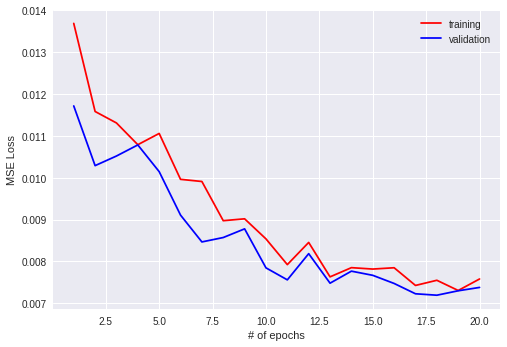

In [0]:
epochs = np.linspace(1,20,num=20)
plt.figure()
plt.plot(epochs, training_loss, 'r')
plt.plot(epochs, testing_loss, 'b')
plt.legend(['training', 'validation'])
plt.xlabel('# of epochs')
plt.ylabel('MSE Loss')
plt.show()

### Test

In [0]:
! ls drive/EM/u-net-em-1

In [0]:
net = Unet()
net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-19-0.007579292838151256.pkl'))

In [0]:
com_imgs_unet = inference(net,imgs_test, img_size=96, batch_size=3)


test images/masks shape:
(4, 1, 576, 576)
test images range (min-max): 0.0 - 0.996078431372549
number of patches per image: 36

test PATCHES images/masks shape:
(144, 1, 96, 96)
test PATCHES images range (min-max): 0.0 - 0.996078431372549
Time cost in this epoch:  45.09627628326416
6 6
iter_tot 144


In [0]:
print(com_imgs_unet.shape)
np.save('drive/EM/com_imgs_unet_test.npy', com_imgs_unet)

(4, 1, 512, 512)


Showing the orginal data:


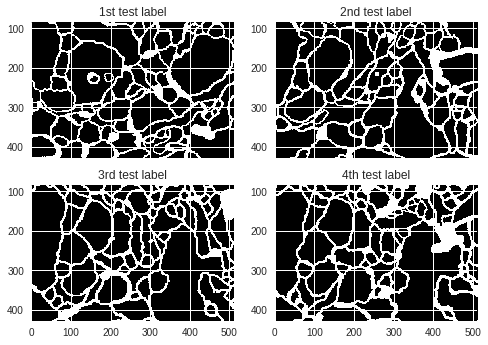

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(label_test[0].reshape((512,512)))
ax[0,1].imshow(label_test[1].reshape((512,512)))
ax[0,0].set_title('1st test label')
ax[1,0].imshow(label_test[2].reshape((512,512)))
ax[0,1].set_title('2nd test label')
ax[1,0].set_title('3rd test label')
ax[1,1].imshow(label_test[3].reshape((512,512)))
ax[1,1].set_title('4th test label')


plt.show()


Showing the orginal data:


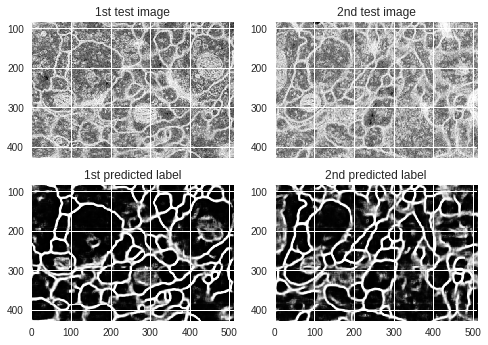

In [0]:
com_imgs_unet = np.load('drive/EM/com_imgs_unet_test.npy')
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(com_imgs_unet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(com_imgs_unet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')
plt.show()


In [0]:
com_imgs_unet = np.load('drive/EM/com_imgs_unet_test.npy')
imgs_unet = com_imgs_unet
imgs_unet[com_imgs_unet<0.5] = 0
imgs_unet[com_imgs_unet>0.5]=255


Showing the orginal data:


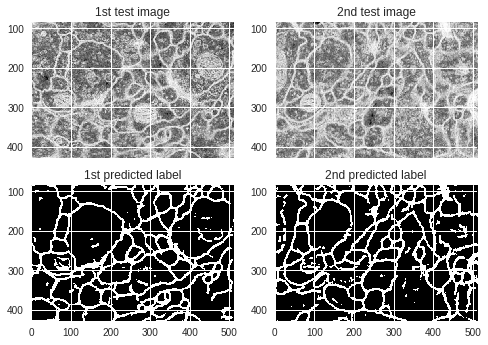

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(imgs_unet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(imgs_unet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')
plt.show()

### Training Seg-net

In [0]:
! mkdir drive/EM/seg-net-em-1

In [0]:
def training(net, dataset_train_split, dataset_valid_split, img_size, batch_size, epoch):
  optimizer = optim.Adam(net.parameters(), lr=0.01, 
                         betas=(0.9, 0.995), eps=1e-05)
  criterion = nn.MSELoss()

  begin = time.time()
  total_loss_train = 0
  bgen = training_batch_generator(dataset_train_split, batch_size)
  net.train()
  for idx, (imgs, masks) in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
      masks = np.asarray(masks).reshape(len(masks), 1, img_size, img_size)
       
      inputs = Variable(torch.from_numpy(imgs).type(dtype))
      targets = Variable(torch.from_numpy(masks).type(dtype))

      optimizer.zero_grad()
      pred = net(inputs)

      loss = criterion(pred, targets)
      loss.backward()

      optimizer.step()

      current_loss = loss.data[0]
      total_loss_train += current_loss

  training_loss = total_loss_train/len(dataset_train_split)
  print('epoch {} -- training loss {}'.format(epoch, training_loss))
  print('----')

  torch.save(net.state_dict(), 'drive/EM/seg-net-em-1/params-{}-{}.pkl'.format(epoch, training_loss))
  print("Checkpoint saved")

  print("Time cost in this epoch: ", time.time()-begin)
    
  
  
  return training_loss

In [0]:
net = Seg_net()
#net.load_state_dict(torch.load('drive/EM/seg-net-em-1/params-9-0.008537114139956732.pkl'))
img_size = 96
training_loss = np.zeros(20);
testing_loss = np.zeros(20);accuracy = np.zeros(20);recall = np.zeros(20);f1 = np.zeros(20);precision =  np.zeros(20)
# Sampling training data
for epoch in range(20):
  dataset_train_split, dataset_valid_split, dataset_train = sampling_training_data(imgs_input, label_input, img_size, Num_patches=600)
  training_loss[epoch]= training(net, dataset_train_split, dataset_valid_split,img_size=img_size, batch_size=10, epoch=epoch)
  testing_loss[epoch]= testing(net, dataset_valid_split, img_size=img_size, batch_size=10)

In [0]:
np.save('drive/EM/seg-net-em-1/training_loss.npy', training_loss)
np.save('drive/EM/seg-net-em-1/testing_loss.npy', testing_loss)

In [0]:
import numpy as np
training_loss = np.load('drive/EM/seg-net-em-1/training_loss.npy')
testing_loss = np.load('drive/EM/seg-net-em-1/testing_loss.npy')

In [0]:
epochs = np.linspace(1,20,num=20)
plt.figure()
plt.plot(epochs, training_loss, 'r')
plt.plot(epochs, testing_loss, 'b')
plt.legend(['training', 'testing'])
plt.xlabel('# of epochs')
plt.ylabel('MSE Loss')
plt.show()

### Test

In [0]:
! ls drive/EM/seg-net-em-1

params-0-0.015985628683120014.pkl   params-2-0.01081046120574077.pkl
params-0-0.016535817505791785.pkl   params-2-0.010993527186413606.pkl
params-10-0.007755227464561661.pkl  params-3-0.009891808203731974.pkl
params-1-0.013035557263841232.pkl   params-3-0.009957340576996406.pkl
params-1-0.01321573321086665.pkl    params-4-0.008895081095397472.pkl
params-11-0.007822166383266448.pkl  params-5-0.008664474411246677.pkl
params-12-0.007369799787799517.pkl  params-6-0.0081798280046011.pkl
params-13-0.007272795378230512.pkl  params-7-0.00817242314418157.pkl
params-14-0.006890388353106876.pkl  params-8-0.008086709391015271.pkl
params-15-0.007087311365952095.pkl  params-9-0.007819070387631655.pkl
params-16-0.007344854654123386.pkl  results_segnet.tif
params-17-0.006918289240760108.pkl  testing_loss.npy
params-18-0.007066779218924542.pkl  training_loss.npy
params-19-0.006958022923208773.pkl


In [0]:
net = Seg_net()
net.load_state_dict(torch.load('drive/EM/seg-net-em-1/params-19-0.006958022923208773.pkl'))

In [0]:
com_imgs_segnet = inference(net,imgs_test, img_size=96, batch_size=3)


test images/masks shape:
(4, 1, 576, 576)
test images range (min-max): 0.0 - 0.996078431372549
number of patches per image: 36

test PATCHES images/masks shape:
(144, 1, 96, 96)
test PATCHES images range (min-max): 0.0 - 0.996078431372549
Time cost in this epoch:  29.742006540298462
6 6
iter_tot 144


In [0]:
print(com_imgs_segnet.shape)
np.save('drive/EM/com_imgs_segnet_test.npy', com_imgs_segnet)

(4, 1, 512, 512)


Showing the orginal data:


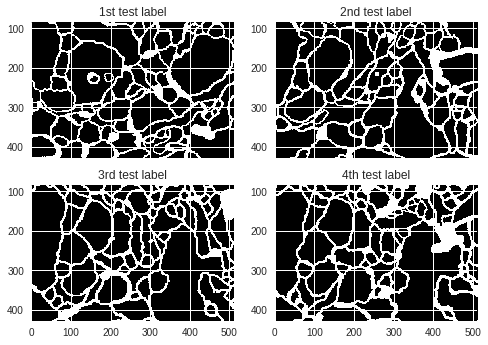

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(label_test[0].reshape((512,512)))
ax[0,1].imshow(label_test[1].reshape((512,512)))
ax[0,0].set_title('1st test label')
ax[1,0].imshow(label_test[2].reshape((512,512)))
ax[0,1].set_title('2nd test label')
ax[1,0].set_title('3rd test label')
ax[1,1].imshow(label_test[3].reshape((512,512)))
ax[1,1].set_title('4th test label')


plt.show()


Showing the orginal data:


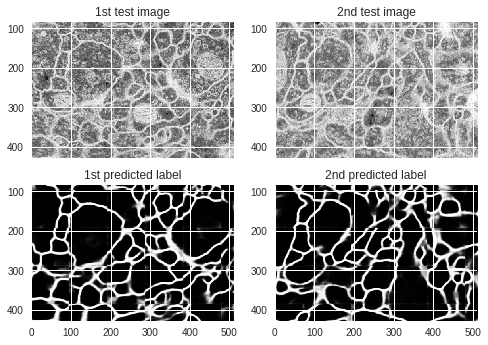

In [0]:
#com_imgs_unet = np.load('drive/EM/com_imgs_unet_test.npy')
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(com_imgs_segnet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(com_imgs_segnet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')
plt.show()


Showing the orginal data:


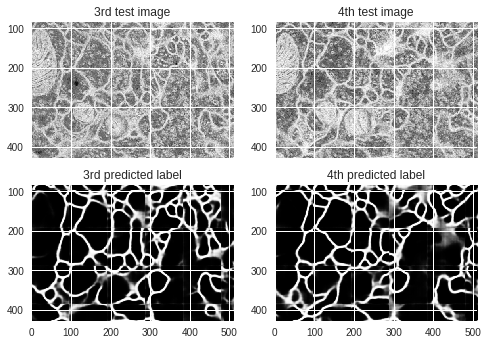

In [0]:
#com_imgs_unet = np.load('drive/EM/com_imgs_unet_test.npy')
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[2].reshape((512,512)))
ax[0,1].imshow(imgs_test[3].reshape((512,512)))
ax[0,0].set_title('3rd test image')
ax[1,0].imshow(com_imgs_segnet[2].reshape((512,512)))
ax[0,1].set_title('4th test image')
ax[1,0].set_title('3rd predicted label')
ax[1,1].imshow(com_imgs_segnet[3].reshape((512,512)))
ax[1,1].set_title('4th predicted label')
plt.show()

In [0]:
import numpy as np
com_imgs_segnet = np.load('drive/EM/com_imgs_segnet_test.npy')
imgs_segnet = com_imgs_segnet
imgs_segnet[com_imgs_segnet<0.5] = 0
imgs_segnet[com_imgs_segnet>0.5]=255

Showing the orginal data:


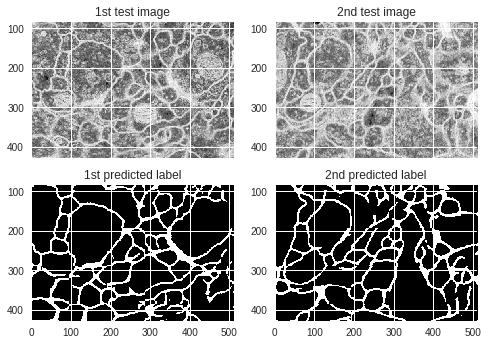

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(imgs_segnet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(imgs_segnet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')
plt.show()

Showing the orginal data:


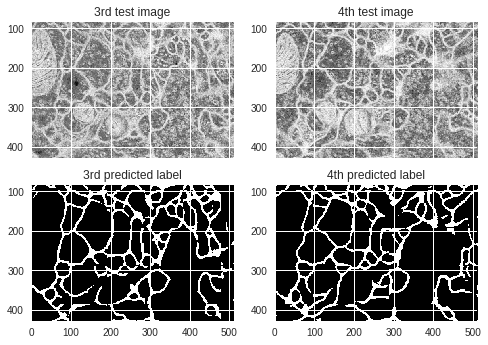

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[2].reshape((512,512)))
ax[0,1].imshow(imgs_test[3].reshape((512,512)))
ax[0,0].set_title('3rd test image')
ax[1,0].imshow(imgs_segnet[2].reshape((512,512)))
ax[0,1].set_title('4th test image')
ax[1,0].set_title('3rd predicted label')
ax[1,1].imshow(imgs_segnet[3].reshape((512,512)))
ax[1,1].set_title('4th predicted label')
plt.show()

# Inference

In [0]:

## Test function
def inference(net, imgs_test, img_size=96, batch_size=10):
  # For Test Data
  test_imgs, test_imgs_ori = get_data_testing(test_imgs_original=imgs_test, 
                                          img_size=img_size)

  dataset_test = [img for img in test_imgs]
  
  image_pred = patches_prediction(dataset_test, net, img_size, batch_size)

  com_img = recombine_image(image_pred, img_size)
  
  return com_img[:, np.newaxis, ...]

#Load the original data and return the extracted patches for training/testing
def get_data_testing(test_imgs_original,
                     img_size=64,
                     N=20):
    patch_height, patch_width = img_size, img_size
    ### test
    test_imgs = my_PreProc(test_imgs_original)
    
    #extend both images and masks so they can be divided exactly by the patches dimensions

    test_imgs = paint_border(test_imgs,patch_height,patch_width)

    #data_consistency_check(test_imgs, test_masks)

    print("\ntest images/masks shape:")
    print(test_imgs.shape)
    print("test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))

    # return test_imgs, test_masks

    #extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)

    print("\ntest PATCHES images/masks shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test)))
    return patches_imgs_test, test_imgs
  
def patches_prediction(dataset_test, net, img_size, batch_size = 10):
  net.eval()
  bgen = batch_generator(dataset_test, batch_size)
  image_pred = np.zeros((len(dataset_test), 1, img_size, img_size))
  begin = time.time()
  for idx, imgs in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)

      inputs = Variable(torch.from_numpy(imgs).type(dtype))

      pred = net(inputs)
      image_pred[idx*batch_size:(idx+1)*batch_size, ...] = pred.data.numpy()

  print("Time cost in this epoch: ", time.time()-begin)
  
  return image_pred

# Recombine patches to a whole image
def recombine_image(image_pred, img_size):
  height = 512
  width = 512
  N_patches_h = int(height/img_size)+1
  N_patches_w = int(width/img_size)+1
  print(N_patches_h, N_patches_w)
  new_img = np.zeros((4, N_patches_h*img_size, N_patches_w*img_size))

  iter_tot = 0
  for i in range(new_img.shape[0]):
    for h in range(N_patches_h):
      for w in range(N_patches_w):
        new_img[i, h*img_size:(h+1)*img_size, w*img_size:(w+1)*img_size] = image_pred[iter_tot][0]
        iter_tot += 1
  print('iter_tot', iter_tot)
  return new_img[:, 0:height, 0:width]


#Extend the full images becasue patch divison is not exact
def paint_border(data,patch_h,patch_w):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    img_h=data.shape[2]
    img_w=data.shape[3]
    new_img_h = 0
    new_img_w = 0
    if (img_h%patch_h)==0:
        new_img_h = img_h
    else:
        new_img_h = (int(img_h/patch_h)+1)*patch_h
    if (img_w%patch_w)==0:
        new_img_w = img_w
    else:
        new_img_w = (int(img_w/patch_w)+1)*patch_w
        
    new_data = np.zeros((data.shape[0],data.shape[1],int(new_img_h), int(new_img_w)))
    new_data[:,:,0:img_h,0:img_w] = data[:,:,:,:]
    return new_data


def batch_generator(dataset, batch_size=5):
    # shuffle(dataset)
    N_full_batches = int(np.ceil(len(dataset) / batch_size))
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        if idx_to>len(dataset):
          idx_to=len(dataset)
        imgs = [img for img in dataset[idx_from:idx_to]]
        yield imgs

### Load test data and trained model

#### Unet

In [0]:
import numpy as np
from skimage import io
from skimage import data_dir

image_test = io.imread('drive/EM/test-volume.tif')

imgs_test = image_test[:,np.newaxis,...]

In [0]:
! ls drive/EM/u-net-em-1

In [0]:
net = Unet()
net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-19-0.007579292838151256.pkl'))

In [0]:
com_imgs_unet = inference(net, imgs_test, img_size=96, batch_size=10)
# remember to make it into binary
#com_imgs_unet[com_imgs< 0.4] = 0
#com_imgs_unet[com_imgs>=0.4]=255
#results = np.squeeze(com_imgs_unet)
#results = results.astype(np.float16)
#io.imsave('drive/EM/u-net-em-1/results_unet.tif', results)
np.save('drive/EM/u-net-em-1/results_unet.npy', com_imgs_unet)

Showing the orginal data:


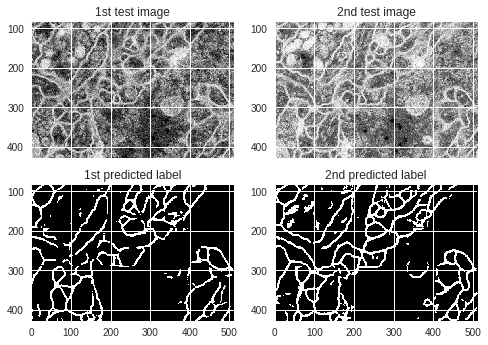

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(com_imgs_unet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(com_imgs_unet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')

plt.show()

#### Segnet

In [0]:
! ls drive/EM/seg-net-em-1

params-0-0.016535817505791785.pkl   params-19-0.006958022923208773.pkl
params-10-0.007755227464561661.pkl  params-2-0.01081046120574077.pkl
params-1-0.013035557263841232.pkl   params-3-0.009891808203731974.pkl
params-11-0.007822166383266448.pkl  params-4-0.008895081095397472.pkl
params-12-0.007369799787799517.pkl  params-5-0.008664474411246677.pkl
params-13-0.007272795378230512.pkl  params-6-0.0081798280046011.pkl
params-14-0.006890388353106876.pkl  params-7-0.00817242314418157.pkl
params-15-0.007087311365952095.pkl  params-8-0.008086709391015271.pkl
params-16-0.007344854654123386.pkl  params-9-0.007819070387631655.pkl
params-17-0.006918289240760108.pkl  testing_loss.npy
params-18-0.007066779218924542.pkl  training_loss.npy


In [0]:
net = Seg_net()
net.load_state_dict(torch.load('drive/EM/seg-net-em-1/params-19-0.006958022923208773.pkl'))

In [0]:
com_imgs_segnet = inference(net, imgs_test, img_size=96, batch_size=10)
com_imgs_segnet[com_imgs< 0.4] = 0
com_imgs_segnet[com_imgs>=0.4]=255
# remember to make it into binary
results = np.squeeze(com_imgs_segnet)
results = results.astype(np.float16)
io.imsave('drive/EM/seg-net-em-1/results_segnet.tif', results)
np.save('drive/EM/u-net-em-1/results_unet.npy', com_imgs_unet)


test images/masks shape:
(30, 1, 576, 576)
test images range (min-max): 0.0 - 1.0
number of patches per image: 36

test PATCHES images/masks shape:
(1080, 1, 96, 96)
test PATCHES images range (min-max): 0.0 - 1.0


In [0]:
pred_test_seg = io.imread('drive/EM/seg-net-em-1/results_segnet.tif')

Showing the orginal data:


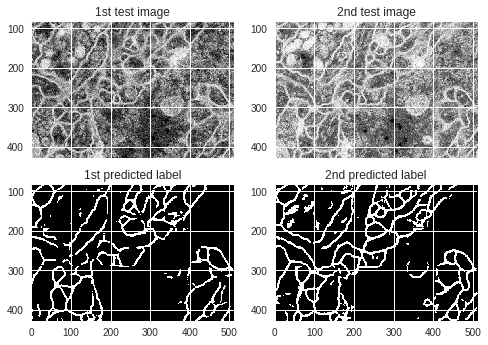

In [0]:
# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(2,2,sharex=True)
ax[0,0].imshow(imgs_test[0].reshape((512,512)))
ax[0,1].imshow(imgs_test[1].reshape((512,512)))
ax[0,0].set_title('1st test image')
ax[1,0].imshow(com_imgs_segnet[0].reshape((512,512)))
ax[0,1].set_title('2nd test image')
ax[1,0].set_title('1st predicted label')
ax[1,1].imshow(com_imgs_segnet[1].reshape((512,512)))
ax[1,1].set_title('2nd predicted label')

plt.show()
